In [1]:
# Import Libraries
import sys
sys.path.append('..\\helpers')

import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw
from functools import reduce

from pywt import dwt2
import math
from scipy import ndimage


# From helpers directory
from preprocessing import Preprocessor
from morphological_sifter import MorphologicalSifter

import display


preprocessor = Preprocessor()
mms = MorphologicalSifter()

plt.rcParams['figure.figsize'] = (20, 18)
plt.style.use('classic')
plt.subplots_adjust(wspace=0, hspace=0)
sns.set()

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

<Figure size 640x480 with 0 Axes>

In [2]:
# Define dataset folder path
dataset_folder_paths = [(x[0].split("\\")[-1], x[0]) for x in os.walk("..\\dataset")][1:]

# Show the paths of the folder
dataset_folder_paths

[('groundtruth', '..\\dataset\\groundtruth'),
 ('images', '..\\dataset\\images'),
 ('masks', '..\\dataset\\masks'),
 ('overlay', '..\\dataset\\overlay'),
 ('processed', '..\\dataset\\processed'),
 ('images', '..\\dataset\\processed\\images')]

In [3]:
# Read image data and make dataframe
positive_labelled_images = []
negative_labelled_images = []

dataset = []
dataset_path = '..\\dataset'

labels = ["positives", "negatives"]

for idx, object in enumerate(labels):
        with open(f'..\\dataset\\{str(object)}.txt') as f:
            lines = f.read().splitlines()
            
            for line in lines:
                if line != "":
                    new_path = os.path.join(dataset_path, 'images', line)
                    
                    dataset.append((str(object), line))
                    positive_labelled_images.append(new_path) if str(object) == 'positives' else negative_labelled_images.append(new_path)

dataset_df = pd.DataFrame(dataset, columns=['class', 'filename'])

# Show the dataframe with lebel (positive and negative)
dataset_df 

,class,filename
0,positives,20586908_6c613a14b80a8591_MG_R_CC_ANON.tif
1,positives,20586934_6c613a14b80a8591_MG_L_CC_ANON.tif
2,positives,20586960_6c613a14b80a8591_MG_R_ML_ANON.tif
3,positives,20586986_6c613a14b80a8591_MG_L_ML_ANON.tif
4,positives,20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif
...,...,...
405,negatives,53587572_11e6732579acf692_MG_L_ML_ANON.tif
406,negatives,53587599_11e6732579acf692_MG_L_CC_ANON.tif
407,negatives,53587690_5fb370d4c1c71974_MG_L_ML_ANON.tif
408,negatives,53587717_5fb370d4c1c71974_MG_R_ML_ANON.tif


In [4]:
# Summary of the dataset
dataset_df.describe()

,class,filename
count,410,410
unique,2,410
top,negatives,20586908_6c613a14b80a8591_MG_R_CC_ANON.tif
freq,303,1


In [5]:
# Duplicate file checking
len(dataset_df["filename"].unique())

410

<AxesSubplot: >

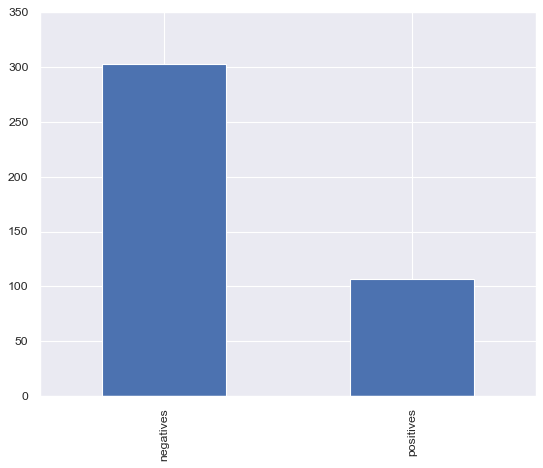

In [6]:
# Visualizing the dataset
dataset_df["class"].value_counts().plot(kind='bar')

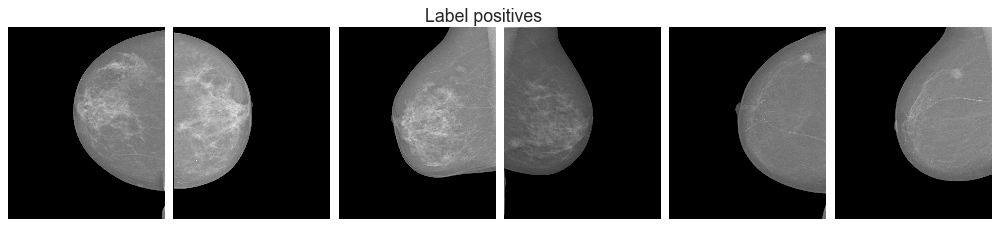

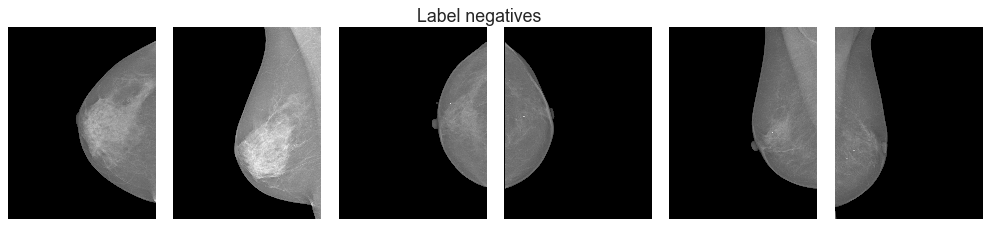

In [7]:
# Plotting images from the dataset
for idx, lbl in enumerate(labels):
    nrows, ncols = 1, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 3))
    plt.subplots_adjust(wspace=0, hspace=1)

    for idx, fname in enumerate(dataset_df.loc[dataset_df['class'] == lbl]['filename'][:ncols]):
        img = Image.open(os.path.join(dataset_path, 'images',fname))
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(np.array(img), cmap='gray')
        fig.suptitle(f'Label {lbl}', fontsize=16)
        plt.axis('off')

In [70]:
# Implementing preprocessing technique on the images
preprocessor.fit(dataset_path=dataset_folder_paths[1][1], process_n=30, plot=False, export_processed=True)


2023-05-01 19:36:13.185 | INFO     | preprocessing:fit:70 - Started processing pipeline.
100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.94it/s]
2023-05-01 19:36:19.281 | INFO     | preprocessing:fit:115 - Finished processing 410 files in approximately 6.096 seconds.


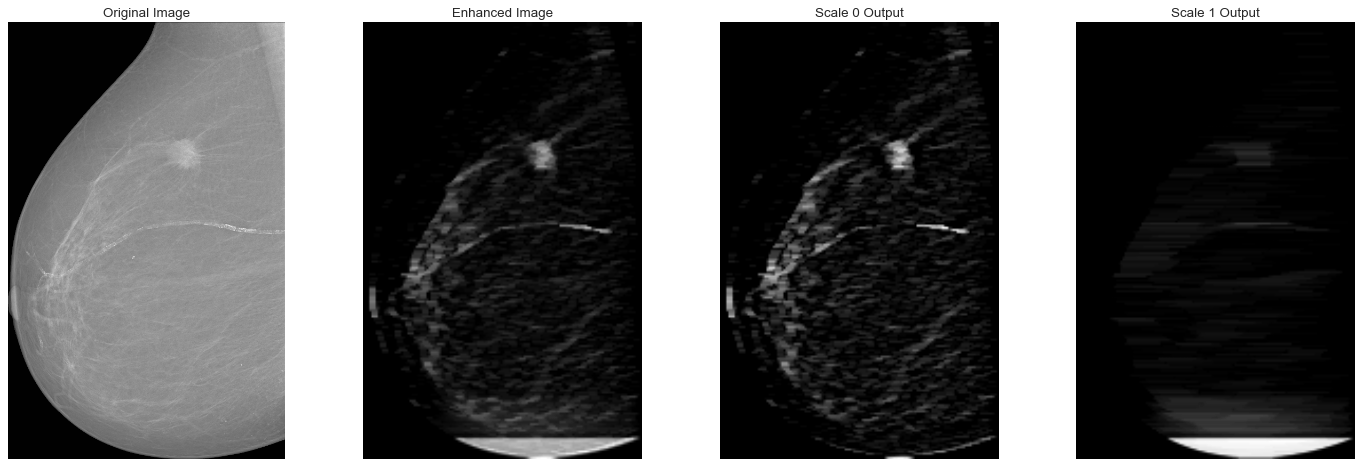

In [72]:
# Implementing multi-scale-morphological sifting (MMS) on the pre-processed image
#image_input_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif'
image_input_name = "20587664_f4b2d377f43ba0bd_MG_R_ML_ANON.tif"
#image_input_name = '20586960_6c613a14b80a8591_MG_R_ML_ANON.tif'

input_image, normalized_image, enhanced_images, LSE_magnitudes = mms.fit(image_input_name, plot=True, test_on_overlay=False)

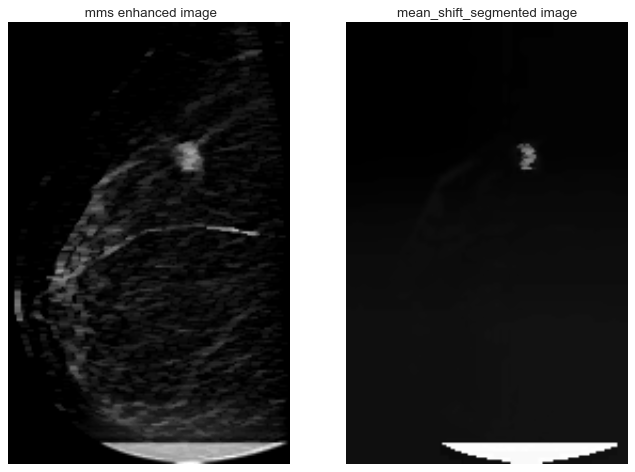

In [73]:
# Apply Mean Shift Segmenation on final MMS Enhanced Image (Not Scale 0 and Scale 1) [without MLT]
normalized_image_norm = cv2.normalize(normalized_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
normalized_image_norm_bgr = cv2.cvtColor(normalized_image_norm, cv2.COLOR_GRAY2BGR)
mean_shift_img_mms = cv2.pyrMeanShiftFiltering(normalized_image_norm_bgr, 55, 65)
mean_shift_img_mms_gray = cv2.cvtColor(mean_shift_img_mms, cv2.COLOR_BGR2GRAY)

# Using the threshold values, we generate the three regions.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

# Plotting the mms enhanced image.
ax[0].imshow(normalized_image, cmap='gray')
ax[0].set_title(' mms enhanced image')
ax[0].axis('off')

# Plotting the Multi Otsu result.
ax[1].imshow(mean_shift_img_mms_gray, cmap='gray')
ax[1].set_title('mean_shift_segmented image')
ax[1].axis('off')

plt.subplots_adjust()
plt.show()

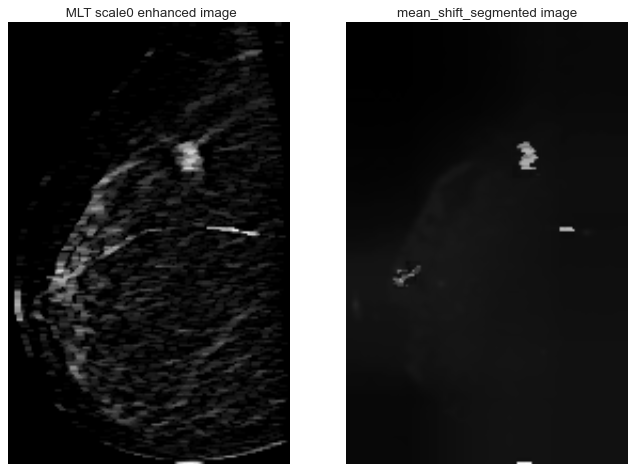

In [74]:
# Apply Mean Shift Segmentation on the [MMS Scaled 0] image
enhanced_image_norm = cv2.normalize(enhanced_images[0], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
enhanced_image_norm_bgr = cv2.cvtColor(enhanced_image_norm, cv2.COLOR_GRAY2BGR)
mean_shift_img_MLT = cv2.pyrMeanShiftFiltering(enhanced_image_norm_bgr, 30, 80)
mean_shift_img_MLT_gray = cv2.cvtColor(mean_shift_img_MLT, cv2.COLOR_BGR2GRAY)

# Using the threshold values, we generate the three regions.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

# Plotting the mms enhanced image.
ax[0].imshow(enhanced_images[0], cmap='gray')
ax[0].set_title(' MLT scale0 enhanced image')
ax[0].axis('off')

# Plotting the Multi Otsu result.
ax[1].imshow(mean_shift_img_MLT_gray, cmap='gray')
ax[1].set_title('mean_shift_segmented image')
ax[1].axis('off')

plt.subplots_adjust()
plt.show()

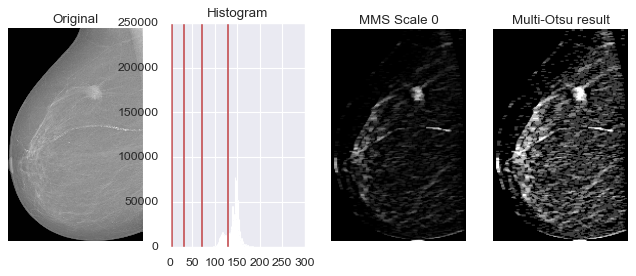

In [75]:
# Implementing Multi level Otsu Thresholding on the MMS (Scale 0) image (Not the final normalized mms image)
from skimage.filters import threshold_multiotsu

# Applying multi-Otsu threshold for the default value, generating
thresholds = threshold_multiotsu(enhanced_images[0], classes=5)

# Using the threshold values, we generate the three regions.
regions = np.digitize(enhanced_images[0], bins=thresholds)

# Using the threshold values, we generate the three regions.
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(input_image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(input_image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')


# Plotting the MMS Scale 0 image.
ax[2].imshow(enhanced_images[0], cmap='gray')
ax[2].set_title('MMS Scale 0')
ax[2].axis('off')

# Plotting the Multi Otsu result.
ax[3].imshow(regions, cmap='gray')
ax[3].set_title('Multi-Otsu result')
ax[3].axis('off')

plt.subplots_adjust()
plt.show()

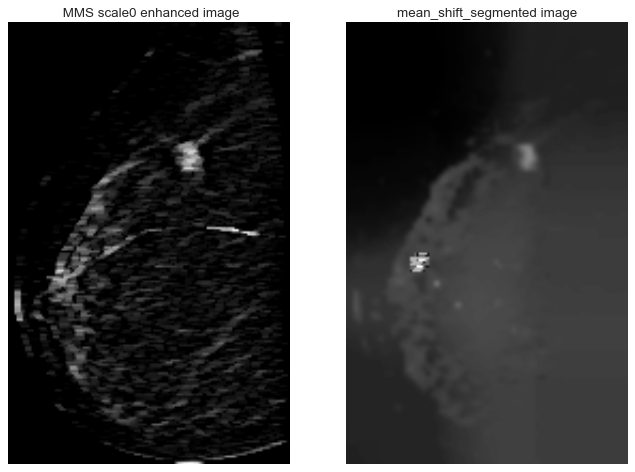

In [76]:
# Apply Mean Shift Segmentation on the [Multi Level Threshold MMS Scaled 0] image
regions_norm = cv2.normalize(regions, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
regions_norm_bgr = cv2.cvtColor(regions_norm, cv2.COLOR_GRAY2BGR)
mean_shift_img_MLT = cv2.pyrMeanShiftFiltering(regions_norm_bgr, 40, 120)
mean_shift_img_MLT_gray = cv2.cvtColor(mean_shift_img_MLT, cv2.COLOR_BGR2GRAY)

# Using the threshold values, we generate the three regions.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

# Plotting the mms enhanced image.
ax[0].imshow(enhanced_images[0], cmap='gray')
ax[0].set_title(' MMS scale0 enhanced image')
ax[0].axis('off')

# Plotting the Multi Otsu result.
ax[1].imshow(mean_shift_img_MLT_gray, cmap='gray')
ax[1].set_title('mean_shift_segmented image')
ax[1].axis('off')

plt.subplots_adjust()
plt.show()

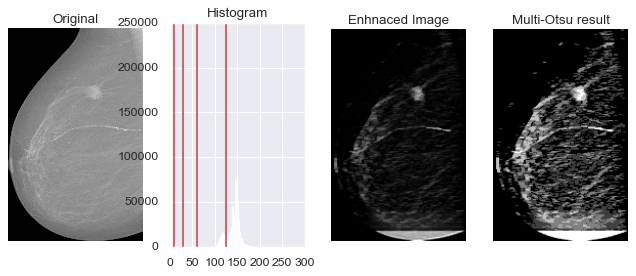

In [77]:
# Implementing Multi level Otsu Thresholding on the final normalized MMS image
normalized_image_norm = cv2.normalize(normalized_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
thresholds = threshold_multiotsu(normalized_image_norm, classes=5)

# Using the threshold values, we generate the three regions.
regions = np.digitize(normalized_image_norm, bins=thresholds)

# Using the threshold values, we generate the three regions.
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(input_image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(input_image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')


# Plotting the MMS Scale 0 image.
ax[2].imshow(normalized_image, cmap='gray')
ax[2].set_title('Enhnaced Image')
ax[2].axis('off')

# Plotting the Multi Otsu result.
ax[3].imshow(regions, cmap='gray')
ax[3].set_title('Multi-Otsu result')
ax[3].axis('off')

plt.subplots_adjust()
plt.show()

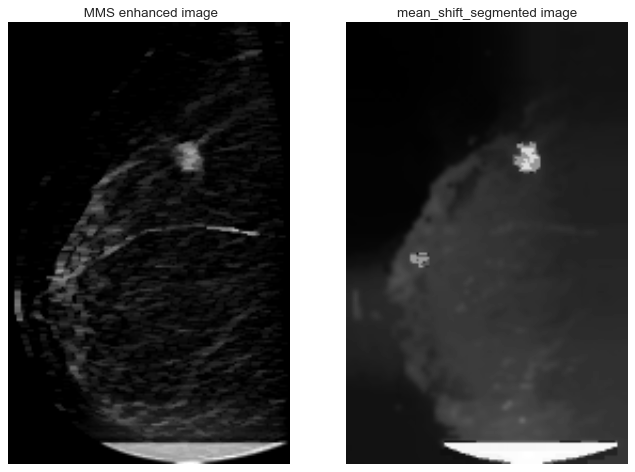

In [78]:
# Apply Mean Shift Segmenation on MLT final MMS Enhanced Image (Not Scale 0 and Scale 1)
regions_image_norm = cv2.normalize(regions, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
regions_image_norm_bgr = cv2.cvtColor(regions_image_norm, cv2.COLOR_GRAY2BGR)
mean_shift_img_mms = cv2.pyrMeanShiftFiltering(regions_image_norm_bgr, 30, 120)
mean_shift_img_mms_gray = cv2.cvtColor(mean_shift_img_mms, cv2.COLOR_BGR2GRAY)

# Using the threshold values, we generate the three regions.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

# Plotting the mms enhanced image.
ax[0].imshow(normalized_image, cmap='gray')
ax[0].set_title(' MMS enhanced image')
ax[0].axis('off')

# Plotting the Multi Otsu result.
ax[1].imshow(mean_shift_img_mms_gray, cmap='gray')
ax[1].set_title('mean_shift_segmented image')
ax[1].axis('off')

plt.subplots_adjust()
plt.show()